# Интерпретация моделей машинного обучения

И снова здравствуйте, ~~новоземельские белые медведи~~ польские бобры. 

Будем решать задачу аппроксимации турбулентных потоков тепла над городскими ландшафтами. 

Используются данные международного проекта [Urban Plumber](https://urban-plumber.github.io/) для точки [PL-Lipova](https://urban-plumber.github.io/PL-Lipowa/) в городе Лодзь. 

Статья про данные: [Lipson et al. (2022, ESSD) Harmonized gap-filled datasets from 20 urban flux tower sites](https://doi.org/10.5194/essd-14-5157-2022)


In [1]:
import os, sys
import pickle as pkl
import xarray as xr
import pandas as pd 
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import ShuffleSplit, KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge   
from sklearn.neighbors import KNeighborsRegressor

from catboost import CatBoostRegressor
from sklearn.svm import SVR

### Читаем данные, удаляем лишнее, понижаем дискретность с 30 мин до 3 ч

In [2]:
ds = xr.open_dataset ("data4model_comparison/PL-Lipowa_raw_observations_v1.nc")

df = ds.to_dataframe()
df = df.drop(columns = [c for c in df.columns if "_qc" in c])
display(df.head())
display(df.describe())

#df.resample('3H').mean()
df_smoothed = df.groupby(pd.Grouper(freq='3h', closed='left', label='left', convention='start')).mean()


,SWdown,LWdown,Tair,Qair,PSurf,Rainf,Snowf,Wind_N,Wind_E,SWup,LWup,Qle,Qh
time,,,,,,,,,,,,,
2008-01-01 00:00:00,-0.05,338.130005,273.040009,0.003802,99700.0,0.0,NaN,-0.255,1.437,0.00,343.760010,97.680000,-1.869
2008-01-01 01:00:00,0.00,339.160004,272.980011,0.003783,99700.0,0.0,NaN,-0.333,1.501,0.00,343.510010,-11.725000,3.217
2008-01-01 02:00:00,0.00,337.899994,272.959991,0.003777,99700.0,0.0,NaN,-0.206,1.328,0.00,343.609985,26.704000,0.219
2008-01-01 03:00:00,0.00,338.149994,272.920013,0.003765,99700.0,0.0,NaN,0.188,0.792,0.45,343.410004,-5.829000,0.352
2008-01-01 04:00:00,0.01,338.839996,272.910004,0.003762,99700.0,0.0,NaN,0.455,1.039,0.60,343.209991,41.268002,-1.121


,SWdown,LWdown,Tair,Qair,PSurf,Rainf,Snowf,Wind_N,Wind_E,SWup,LWup,Qle,Qh
count,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,0.0,38455.000000,38455.000000,40369.000000,40369.000000,29193.000000,29196.000000
mean,123.889549,344.117676,282.331848,0.006654,98924.929688,0.000015,NaN,0.263691,0.468939,13.019703,399.141083,20.190529,34.463863
std,205.480896,50.961803,8.913330,0.003236,852.744202,0.000119,NaN,2.423843,2.431707,18.432878,59.382599,32.610863,66.810616
min,-6.760000,170.149994,254.410004,0.000605,95250.000000,0.000000,NaN,-10.531000,-8.752000,-4.230000,255.740005,-98.999001,-98.473999
25%,-0.730000,312.527496,275.899994,0.004191,98400.000000,0.000000,NaN,-1.394000,-1.299000,1.370000,353.779999,2.950000,-5.444500
50%,4.900000,346.510010,282.489990,0.006156,98980.000000,0.000000,NaN,0.187000,0.675000,2.740000,391.700012,11.523000,9.251500
75%,166.372501,379.609985,289.230011,0.008769,99450.000000,0.000000,NaN,2.130000,2.121000,19.600000,439.359985,29.500999,49.053749
max,955.809998,493.380005,307.149994,0.018955,101720.000000,0.007722,NaN,10.599000,9.964000,214.699997,616.409973,317.648010,482.760010


In [3]:
%matplotlib qt
df['Qh'].plot()
df_smoothed['Qh'].plot()

<Axes: xlabel='time'>

### Немного feature engineering

In [4]:
df4ml = df_smoothed.drop (columns=['Snowf', 'SWup'])
df4ml = df4ml.dropna()
df4ml = df4ml.sample(2000).sort_values('time')

df4ml['Wind_vel'] = np.sqrt (df4ml['Wind_N']**2 + df4ml['Wind_E']**2)
sigma = 5.67*(10**-8)

df4ml['Ts'] = (df4ml['LWup'] / sigma) **0.25 - 273.15
df4ml['delta_T'] = df4ml['Ts'] - df4ml['Tair']

es =  6.112 * np.exp((17.67 * (df4ml['Tair'] - 273.15))/(df4ml['Tair'] - 273.15 + 243.5))
e = df4ml['Qair']  * (df4ml['PSurf']/100)  / (0.378 * df4ml['Qair'] + 0.622)

df4ml['RHair'] = 100*(e / es) 
df4ml = df4ml.drop (columns=['LWup'])

display(df4ml.describe())


,SWdown,LWdown,Tair,Qair,PSurf,Rainf,Wind_N,Wind_E,Qle,Qh,Wind_vel,Ts,delta_T,RHair
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,137.200592,341.764923,282.205872,0.006388,98975.031250,0.000008,0.373437,0.347445,19.376102,34.265999,2.986741,16.167870,-266.038025,81.272591
std,207.891678,49.621777,8.665579,0.003102,838.499023,0.000062,2.246182,2.327986,28.622761,63.755234,1.341665,10.584812,2.782729,17.506624
min,-3.726667,190.583328,255.779984,0.000726,95400.000000,0.000000,-8.008000,-6.628334,-98.930000,-74.588997,0.078952,-12.336517,-271.754120,25.871382
25%,-0.387500,308.425003,275.809166,0.004042,98493.335938,0.000000,-1.211833,-1.438000,3.486250,-3.946250,2.102763,8.102448,-267.897789,68.700918
50%,21.730000,344.784988,282.266663,0.005858,99026.664062,0.000000,0.377000,0.484833,11.797167,10.090334,2.872986,15.340454,-266.889206,85.859150
75%,208.145844,375.752510,288.940002,0.008361,99500.000000,0.000000,2.129583,2.048250,28.395500,46.322834,3.695998,23.901398,-265.161415,96.265890
max,866.889954,475.699982,305.696686,0.017015,101706.664062,0.001963,7.277334,8.566000,164.257004,388.449005,9.110139,47.493134,-254.666779,100.939857


<Axes: >

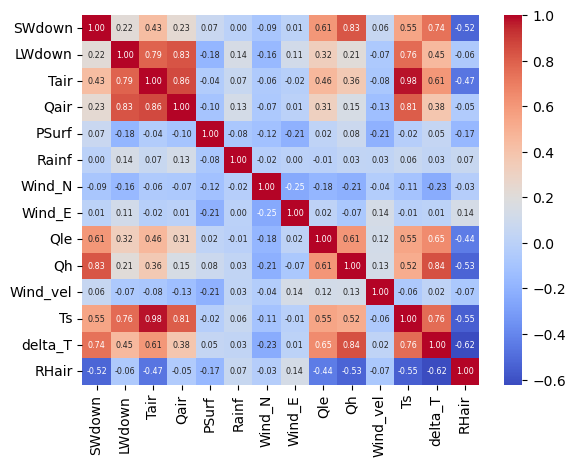

In [5]:
%matplotlib inline
sns.heatmap (df4ml.corr(), annot=True, cmap="coolwarm", fmt=".2f", annot_kws={'size': 'xx-small'})

### Создадим класс-генератор для порождения бутстрэп-выборок, совместимый с штатными методами кросс-валидации sklearn

In [7]:
class BootstrapCV:
    
    def __init__(self, n_splits, sample_size, random_state = 42):
        self.n_splits = n_splits
        self.random_state = random_state
        self.sample_size = sample_size

    def split(self, X, y=None, groups=None):
        np.random.seed (self.random_state)
        for i in range(self.n_splits):
            sample_indices = np.random.randint(0,X.shape[0], self.sample_size)
            oob_indices = np.array([i for i in np.arange(0, X.shape[0], 1, dtype=int) if i not in sample_indices])
            yield sample_indices, oob_indices
    
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

In [11]:
target = 'Qh'
X = df4ml.drop (columns=['Qh', 'Qle'])
Y = df4ml[target]

models = [LinearRegression (), 
          KNeighborsRegressor (),
          RandomForestRegressor (),
          GradientBoostingRegressor (), 
          SVR()] 

cv = BootstrapCV (n_splits=20, sample_size=int (Y.shape[0]*0.95), random_state = 42)

normalization = True

scores = {}

for model in tqdm(models):

    model_pp = Pipeline([
                        ('scaler', StandardScaler(with_mean=normalization, with_std=normalization)),
                        ('regressor', TransformedTargetRegressor(regressor=model, transformer=StandardScaler(with_mean=normalization, with_std=normalization)))
                        ])

    scores4model = cross_validate(model_pp, X, Y, cv=cv, n_jobs=8,
                                  scoring=['r2', 'neg_root_mean_squared_error'], return_train_score = True, return_estimator=True, return_indices=True)

    scores4model['train_idx'] = scores4model['indices']['train']
    scores4model['test_idx'] = scores4model['indices']['test']
    scores4model.pop('indices')
    
    scores4model['model'] = model.__class__.__name__
    scores[model.__class__.__name__] = scores4model


100%|██████████| 5/5 [00:23<00:00,  4.69s/it]


In [12]:
scores_df = pd.concat ([pd.DataFrame(scores[model]) for model in scores.keys()], ignore_index=True)

scores_df['test_rmse'] = -scores_df['test_neg_root_mean_squared_error']
scores_df['train_rmse'] = -scores_df['train_neg_root_mean_squared_error']

scores_df.head()



,fit_time,score_time,estimator,test_r2,train_r2,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,train_idx,test_idx,model,test_rmse,train_rmse
0,0.078886,0.003525,"(StandardScaler(), TransformedTargetRegressor(...",0.840253,0.862004,-24.531214,-23.753817,"[1126, 1459, 860, 1294, 1130, 1095, 1724, 1044...","[2, 15, 18, 23, 25, 29, 30, 32, 39, 43, 44, 45...",LinearRegression,24.531214,23.753817
1,0.075872,0.003523,"(StandardScaler(), TransformedTargetRegressor(...",0.853596,0.868885,-24.391441,-23.657030,"[757, 405, 68, 1335, 1312, 1785, 1571, 750, 11...","[0, 3, 4, 5, 7, 12, 14, 17, 19, 25, 26, 29, 30...",LinearRegression,24.391441,23.657030
2,0.080995,0.005939,"(StandardScaler(), TransformedTargetRegressor(...",0.828628,0.870356,-24.421194,-23.837845,"[739, 1373, 182, 112, 1206, 480, 1169, 830, 16...","[1, 3, 5, 8, 10, 12, 13, 15, 17, 19, 23, 26, 2...",LinearRegression,24.421194,23.837845
3,0.071953,0.005444,"(StandardScaler(), TransformedTargetRegressor(...",0.859572,0.851330,-23.878483,-24.926430,"[1970, 205, 1208, 1405, 495, 1402, 1070, 1909,...","[0, 1, 3, 6, 8, 11, 13, 14, 15, 17, 22, 23, 27...",LinearRegression,23.878483,24.926430
4,0.058714,0.003852,"(StandardScaler(), TransformedTargetRegressor(...",0.865548,0.850635,-24.079641,-24.125895,"[1908, 732, 422, 571, 1633, 170, 1405, 172, 66...","[4, 9, 10, 17, 19, 22, 23, 24, 25, 30, 36, 37,...",LinearRegression,24.079641,24.125895


### Сравним значимость признаков для отдельных реализаций моделей

c:\Anaconda\envs\ML\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


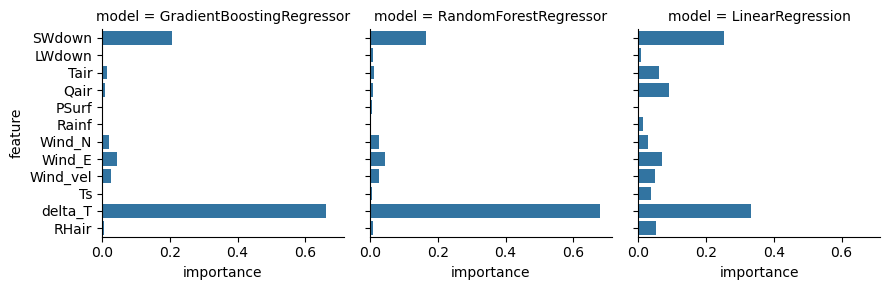

In [13]:
%matplotlib inline

imp_gbr = pd.DataFrame ({'importance': scores_df[scores_df['model'] == 'GradientBoostingRegressor'].iloc[0]['estimator']['regressor'].regressor_.feature_importances_,
                        'model': 'GradientBoostingRegressor', 'feature': X.columns})
imp_rfr = pd.DataFrame ({'importance': scores_df[scores_df['model'] == 'RandomForestRegressor'].iloc[0]['estimator']['regressor'].regressor_.feature_importances_,
                        'model': 'RandomForestRegressor', 'feature': X.columns})
imp_lr = pd.DataFrame ({'importance': scores_df[scores_df['model'] == 'LinearRegression'].iloc[0]['estimator']['regressor'].regressor_.coef_,
                        'model': 'LinearRegression', 'feature': X.columns})

imp_lr['importance'] = np.abs(imp_lr['importance']) / np.sum(np.abs(imp_lr['importance']))

imp = pd.concat([imp_gbr, imp_rfr, imp_lr], axis=0)

g = sns.FacetGrid (imp, col = 'model')
g.map (sns.barplot, 'importance', 'feature')


## Считаем заново прогнозные значения целевой переменной для тестовой и тренировочной выборок
### (и здесь же собираем вместе данные по важности предикторов для всех реализаций)

Это нужно, так как сross_validate их не возвращает, а мы хотим построить диаграмму рассеяния. Записываем их в один большой DataFrame.

In [14]:
reg_results = []
feature_importance = []

for i in scores_df.index:
    train_idx = scores_df.loc[i, 'train_idx']
    test_idx =  scores_df.loc[i, 'test_idx']
    
    cur_Y_train = Y.iloc[train_idx]
    cur_Y_test  = Y.iloc[test_idx]

    cur_X_train = X.iloc[train_idx]
    cur_X_test  = X.iloc[test_idx]

    cur_Y_train_pred = scores_df.loc[i, 'estimator'].predict(cur_X_train)
    cur_Y_test_pred  = scores_df.loc[i, 'estimator'].predict(cur_X_test)

    reg_results.append (pd.DataFrame({'Y':cur_Y_train, 'Y_pred':cur_Y_train_pred, 'model': scores_df.loc[i,'model'], 'type': 'train'}))
    reg_results.append (pd.DataFrame({'Y':cur_Y_test,  'Y_pred':cur_Y_test_pred,  'model': scores_df.loc[i,'model'], 'type': 'test'}))

    if hasattr(scores_df.loc[i, 'estimator']['regressor'].regressor_, 'feature_importances_'):
        importance = scores_df.loc[i, 'estimator']['regressor'].regressor_.feature_importances_
    elif hasattr(scores_df.loc[i, 'estimator']['regressor'].regressor_, 'coef_'):
        importance = scores_df.loc[i, 'estimator']['regressor'].regressor_.coef_
        importance = np.abs(importance) / np.sum(np.abs(importance))
    else:
        importance = None

    if importance is not None:
        feature_importance.append(pd.DataFrame({'importance': importance, 'model': scores_df['model'][i], 'feature': X.columns}))   

    
reg_results = pd.concat(reg_results)

feature_importance = pd.concat(feature_importance)

In [15]:
feature_importance

,importance,model,feature
0,0.252537,LinearRegression,SWdown
1,0.007712,LinearRegression,LWdown
2,0.060841,LinearRegression,Tair
3,0.090253,LinearRegression,Qair
4,0.002057,LinearRegression,PSurf
...,...,...,...
7,0.040970,GradientBoostingRegressor,Wind_E
8,0.025777,GradientBoostingRegressor,Wind_vel
9,0.002708,GradientBoostingRegressor,Ts
10,0.618683,GradientBoostingRegressor,delta_T


### Сравним значимость признаков для ансамбля моделей с учетом неопределенности

c:\Anaconda\envs\ML\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


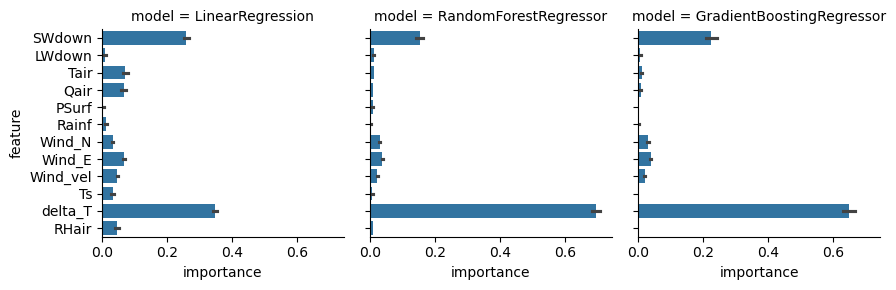

In [16]:
g = sns.FacetGrid (feature_importance, col = 'model')
g.map (sns.barplot, 'importance', 'feature')

### Применим метод permutation_importance

In [17]:
from sklearn.inspection import permutation_importance

feature_importance = []

for i in tqdm (scores_df.index):
    cur_Y_test  = Y.iloc[scores_df.loc[i, 'test_idx']]
    cur_X_test  = X.iloc[scores_df.loc[i, 'test_idx']]

    result = permutation_importance(scores_df.loc[i, 'estimator'], cur_X_test, cur_Y_test, n_repeats=5,
                                    random_state=0, n_jobs = 8, scoring='neg_root_mean_squared_error')

    feature_importance.append(pd.DataFrame({'importance': result['importances_mean']/np.sum(result['importances_mean']),
                                            'model': scores_df['model'][i], 'feature': X.columns}))   

feature_importance = pd.concat(feature_importance)

100%|██████████| 100/100 [01:39<00:00,  1.00it/s]


In [18]:
result

{'importances_mean': array([20.13690014,  2.32401549,  3.59323077,  2.61485463,  0.61060106,
         0.65036225,  2.02159258,  9.0068929 ,  4.38664152,  5.69816036,
        38.56298415,  2.99861157]),
 'importances_std': array([1.01751871, 0.53120794, 0.69072621, 0.42301909, 0.40400245,
        0.6070846 , 0.1689237 , 1.01026679, 0.43922499, 0.74900229,
        1.25659772, 0.15247211]),
 'importances': array([[1.96333159e+01, 1.98623256e+01, 1.94435531e+01, 2.21541246e+01,
         1.95911814e+01],
        [2.23090837e+00, 2.10814138e+00, 1.87269186e+00, 3.36102180e+00,
         2.04731402e+00],
        [3.87227598e+00, 3.54768377e+00, 2.57718230e+00, 4.67985681e+00,
         3.28915498e+00],
        [2.24656546e+00, 2.73892195e+00, 2.18842660e+00, 3.36064861e+00,
         2.53971053e+00],
        [5.36104480e-01, 1.24950246e+00, 7.94224789e-01, 4.47364068e-01,
         2.58094835e-02],
        [9.17011011e-01, 1.10985283e-01, 1.71988458e+00, 3.50481647e-01,
         1.53448702e-01],


c:\Anaconda\envs\ML\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


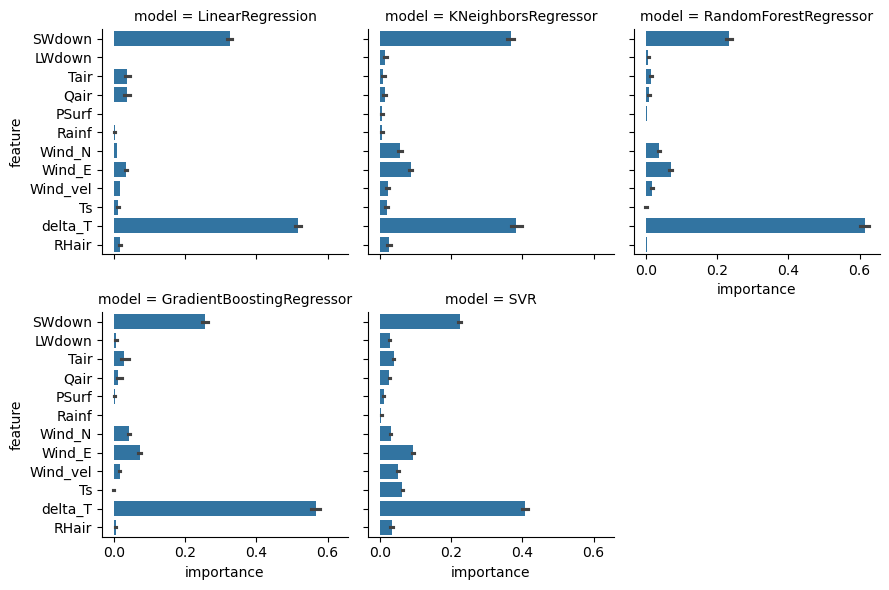

In [19]:
g = sns.FacetGrid (feature_importance, col = 'model', col_wrap=3)
g.map (sns.barplot, 'importance', 'feature')

### Построим диаграммы рассеяния по всем тестовым bootstrap-выборкам

In [ ]:
def myhexbin(*args, **kwargs):
        kwargs.pop("color", None)
        hb = plt.hexbin(*args, **kwargs)
        return hb

plt.figure()
g = sns.FacetGrid (reg_results, col = 'model', row='type')
g.map(plt.scatter, 'Y', 'Y_pred', s=1, color = 'black') 
g.map(myhexbin, 'Y', 'Y_pred', mincnt=1, gridsize=18, alpha = 0.5, edgecolor = None) 

for ax in g.axes.flatten():
        ax.set_title(ax.title.get_text().replace('|', '\n'), fontsize='small')
        ax.set_aspect(1) #'equal')
        ax.grid(zorder=0)



## Посмотрим на метрики качества и их неопределенность для разных bootstrap-выборок. 

In [ ]:

for metric in ['r2', 'rmse']:
    df1 = scores_df[['model', 'train_' + metric]].rename(columns={'train_' + metric: metric,})
    df2 = scores_df[['model', 'test_' + metric]].rename(columns={'test_' + metric: metric,})

    df1['type'] = 'train'
    df2['type'] = 'test'
    df2boxplot = pd.concat([df1, df2])

    plt.figure()
    sns.boxplot (df2boxplot, x='model', y=metric, hue='type', palette='Set1')
    _ = plt.xticks(rotation=45)
    plt.grid()

